In [1]:
import glob
import os

import imageio
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from torchvision.transforms import ToTensor

from lcapt.analysis import make_feature_grid
from lcapt.lca import LCAConv2D
from lcapt.metric import compute_frac_active, compute_l1_sparsity, compute_l2_error
from lcapt.preproc import make_unit_var, make_zero_mean

In [3]:
lca = torch.load("../models/lca_imagenet_vid_dict.pth")
lca.module.weights.shape
v1_activity_distribution_array = np.array(v1_activity_distribution)
v1_overall_mean_batch64_array = np.array(v1_overall_mean_batch64)
print(v1_overall_mean_batch64_array[:, n])
v1_overall_mean_batch64_array.shape[0] * v1_overall_mean_batch64_array.shape[1]
# bool_v1distribution = np.where(v1_activity_distribution > 0, 1, 0)
v1_activity_distribution_array = np.array(v1_activity_distribution)
v1_overall_mean_batch64_array = np.array(v1_overall_mean_batch64)
bool_freq_df = pd.DataFrame(columns=["neuron", "frequency"])

for n in range(v1_overall_mean_batch64_array.shape[1]):
    bool_freq_df.loc[n, "frequency"] = sum(v1_overall_mean_batch64_array[:, n]) / (
        v1_overall_mean_batch64_array.shape[0] * v1_overall_mean_batch64_array.shape[1] * 100
    )

    bool_freq_df.loc[n, "neuron"] = n + 1

mean_sparsity = bool_freq_df["frequency"].mean()
mean_sparsity_df = bool_freq_df * 0 + mean_sparsity
ax1 = bool_freq_df.plot.bar(x="neuron", y="frequency", figsize=(25, 10), legend=False)
mean_sparsity_df.plot(ax=ax1, color="r", title=f"average sparsity: {mean_sparsity}", legend=False)

ax2 = bool_freq_df.sort_values(by=["frequency"], ascending=False).plot.bar(
    x="neuron", y="frequency", figsize=(25, 10), legend=False
)
mean_sparsity_df.plot(ax=ax2, color="r", title=f"average sparsity: {mean_sparsity}", legend=False)

torch.Size([140, 1, 7, 9, 9])

In [7]:
weight_grid = make_feature_grid(lca.module.get_weights())
weight_grid.shape

torch.Size([7, 145, 123, 3])

In [13]:
BATCH_SIZE = 100
EPOCHS = 1
FEATURES = 140  # number of dictionary features to learn
KERNEL_SIZE = 9  # height and width of each feature
LAMBDA = 1.0  # LCA threshold
LCA_ITERS = 1000
PRINT_FREQ = 10
STRIDE = 2  # convolutional stride
TAU = 100  # LCA time constant

In [ ]:
for epoch in range(EPOCHS):
    v1_sparsity_distribution_list = []
    v1_activity_distribution_list = []
    v1_fraction_distribution_list = []
    for batch_num, (images, _) in enumerate(dataloader):
        images = images.cuda()
        images = make_unit_var(make_zero_mean(images))

        code = lca(images)
        v1_activity_distribution_list.append(code)
        v1_fraction_distribution_list.append(compute_frac_active(code))
        v1_sparsity_distribution_list.append(compute_l1_sparsity(code, lca.module.lambda_).item())

        recon = lca.module.compute_recon(code, lca.module.weights)
        recon_error = images - recon
        lca.module.update_weights(code, recon_error)

        if batch_num % PRINT_FREQ == 0:
            l1_sparsity = compute_l1_sparsity(code, lca.module.lambda_).item()
            l2_recon_error = compute_l2_error(images, recon).item()
            total_energy = l2_recon_error + l1_sparsity

            print(
                f"L2 Recon Error: {round(l2_recon_error, 2)}; ",
                f"L1 Sparsity: {round(l1_sparsity, 2)}; ",
                f"Total Energy: {round(total_energy, 2)}",
                f"acts_all: {code.shape}",
                f"batch_num: {batch_num}",
                f"nonzero_counter on activity: {torch.count_nonzero(code)}",
            )

    torch.save(lca, f"save_{epoch}.pth")

torch.Size([140, 1, 7, 9, 9])


TypeError: Invalid shape (7, 145, 123, 3) for image data

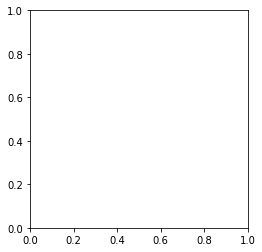

In [11]:
weight_grid = make_feature_grid(lca.module.get_weights())
print(lca.module.get_weights().shape)
plt.imshow(weight_grid.cpu().numpy())